# Final Simulation - MATH 789

### BNPL Simulation — Assumptions

User + GMV Model
- Simulation is based on **GMV per user per year**.
- Annual GMV per user follows a **log-normal distribution**:
  - Mean ≈ \$800
  - Realistic long-tail spending behavior
- Total simulated users: **N_USERS = 50,000**

Risk Model (Realistic BNPL-Style)
Risk tiers based on approximate Klarna-like performance bands:
- **Tier A (Low Risk)**  
  - PD = 0.3%  
  - 50% of users  
- **Tier B (Medium Risk)**  
  - PD = 1.5%  
  - 30% of users  
- **Tier C (High Risk)**  
  - PD = 4.0%  
  - 15% of users  
- **Tier D (Very High Risk)**  
  - PD = 10.0%  
  - 5% of users  

Loss Given Default (LGD): **85%**

Unit Economics
- Merchant Discount Rate (MDR): **3% of GMV**
- Late fee (only when default occurs): **\$3 per defaulting user**
- Cost to serve:
  - **\$0.40 fixed per user**
  - **0.5% variable cost per GMV**

Simulation
- Monte Carlo runs: **200**
- Outputs:
  - Revenue  
  - Expected + realized losses  
  - Cost  
  - Profit distribution  
  - Summary statistics  
  - Profit histogram


### Cell 2 - Imports and parameters

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
N_USERS = 50_000
SIMS = 200

# GMV distribution settings
gmv_mean = 800
gmv_sigma = 0.7  # controls long-tail


### CELL 3 — Generate Synthetic User Base

In [49]:
# Log-normal GMV distribution
mu = np.log(gmv_mean) - (gmv_sigma**2 / 2)
user_gmv = np.random.lognormal(mean=mu, sigma=gmv_sigma, size=N_USERS)

users = pd.DataFrame({
    "user_id": np.arange(N_USERS),
    "annual_gmv": user_gmv
})

users.head()

,user_id,annual_gmv
0,0,725.678860
1,1,657.931134
2,2,643.664305
3,3,348.167225
4,4,233.570305


### Cell 4 - Assign Risk Tiers (Realistic Distributions)

In [50]:
tiers = [
    ("A", 0.003, 0.50),
    ("B", 0.015, 0.30),
    ("C", 0.040, 0.15),
    ("D", 0.100, 0.05),
]

tier_labels, tier_pds, tier_weights = zip(*tiers)

# Assign tiers with weighted sampling
users["risk_tier"] = np.random.choice(
    tier_labels,
    size=N_USERS,
    p=tier_weights
)

# Map PD from tiers
pd_map = {t: pd for t, pd, w in tiers}
users["pd"] = users["risk_tier"].map(pd_map)

# LGD constant
LGD = 0.85
users["lgd"] = LGD

users.head()


,user_id,annual_gmv,risk_tier,pd,lgd
0,0,725.678860,A,0.003,0.85
1,1,657.931134,A,0.003,0.85
2,2,643.664305,B,0.015,0.85
3,3,348.167225,A,0.003,0.85
4,4,233.570305,C,0.040,0.85


### Cell 5 - Unit Economics Function

In [51]:
# Economic assumptions
MDR = 0.03
LATE_FEE = 3.0
COST_FIXED = 0.40
COST_VARIABLE = 0.005  # 0.5%

def compute_unit_economics(df):
    df = df.copy()

    # Revenue
    df["rev_mdr"] = df["annual_gmv"] * MDR
    df["rev_late"] = df["pd"] * LATE_FEE

    # Expected credit losses
    df["expected_losses"] = df["annual_gmv"] * df["pd"] * df["lgd"]

    # Costs
    df["cost_fixed"] = COST_FIXED
    df["cost_variable"] = df["annual_gmv"] * COST_VARIABLE
    df["total_cost"] = df["cost_fixed"] + df["cost_variable"]

    # Contribution margin
    df["contribution"] = (
        df["rev_mdr"] +
        df["rev_late"] -
        df["expected_losses"] -
        df["total_cost"]
    )

    return df

snapshot = compute_unit_economics(users)
snapshot.head()


,user_id,annual_gmv,risk_tier,pd,lgd,rev_mdr,rev_late,expected_losses,cost_fixed,cost_variable,total_cost,contribution
0,0,725.678860,A,0.003,0.85,21.770366,0.009,1.850481,0.4,3.628394,4.028394,15.900490
1,1,657.931134,A,0.003,0.85,19.737934,0.009,1.677724,0.4,3.289656,3.689656,14.379554
2,2,643.664305,B,0.015,0.85,19.309929,0.045,8.206720,0.4,3.218322,3.618322,7.529888
3,3,348.167225,A,0.003,0.85,10.445017,0.009,0.887826,0.4,1.740836,2.140836,7.425354
4,4,233.570305,C,0.040,0.85,7.007109,0.120,7.941390,0.4,1.167852,1.567852,-2.382133


### Cell 6 - Monte Carlo Simulation

In [52]:
results = []

for _ in range(SIMS):
    # Realized defaults
    defaults = np.random.binomial(1, snapshot["pd"])
    realized_losses = snapshot["annual_gmv"] * defaults * snapshot["lgd"]

    # Revenues
    rev_mdr = snapshot["rev_mdr"].sum()
    rev_late = (defaults * LATE_FEE).sum()

    # Costs
    total_cost = snapshot["total_cost"].sum()

    # Totals
    sim_rev = rev_mdr + rev_late
    sim_loss = realized_losses.sum()
    sim_profit = sim_rev - sim_loss - total_cost

    results.append({
        "revenue": sim_rev,
        "losses": sim_loss,
        "costs": total_cost,
        "profit": sim_profit
    })

results_df = pd.DataFrame(results)
results_df.describe()


,revenue,losses,costs,profit
count,2.000000e+02,200.000000,2.000000e+02,200.000000
mean,1.193715e+06,578117.973285,2.185252e+05,397071.628639
std,7.897494e+01,24586.821519,5.835373e-10,24525.501167
min,1.193506e+06,515968.249339,2.185252e+05,349386.459968
25%,1.193662e+06,560292.095716,2.185252e+05,376211.632934
50%,1.193712e+06,576787.580194,2.185252e+05,398395.391624
75%,1.193770e+06,599080.028989,2.185252e+05,414840.566208
max,1.193914e+06,625948.701956,2.185252e+05,459078.912584


### Cell 7 - Profit Distribution Plot

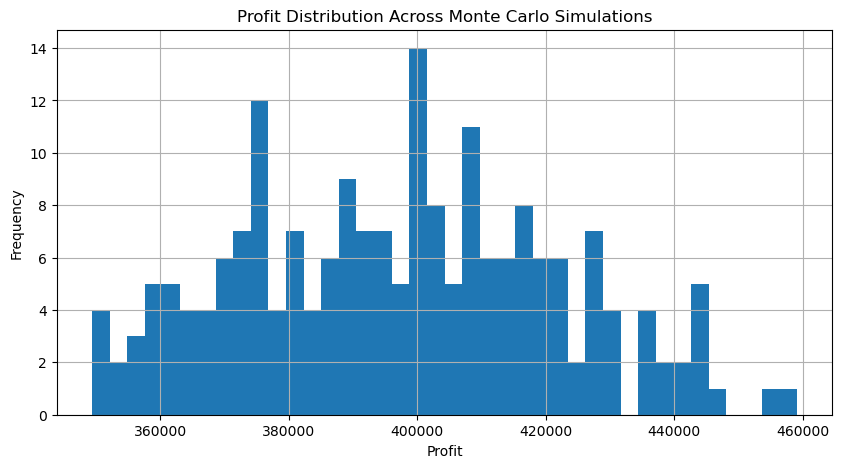

In [53]:
plt.figure(figsize=(10, 5))
plt.hist(results_df["profit"], bins=40)
plt.title("Profit Distribution Across Monte Carlo Simulations")
plt.xlabel("Profit")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


### Cell 8 - Summary Table

In [54]:
summary = results_df.mean().to_frame("mean")
summary["std"] = results_df.std()
summary


,mean,std
revenue,1.193715e+06,7.897494e+01
losses,5.781180e+05,2.458682e+04
costs,2.185252e+05,5.835373e-10
profit,3.970716e+05,2.452550e+04


### Cell 9 - Breakeven Sensitivity (GMV × PD Grid)

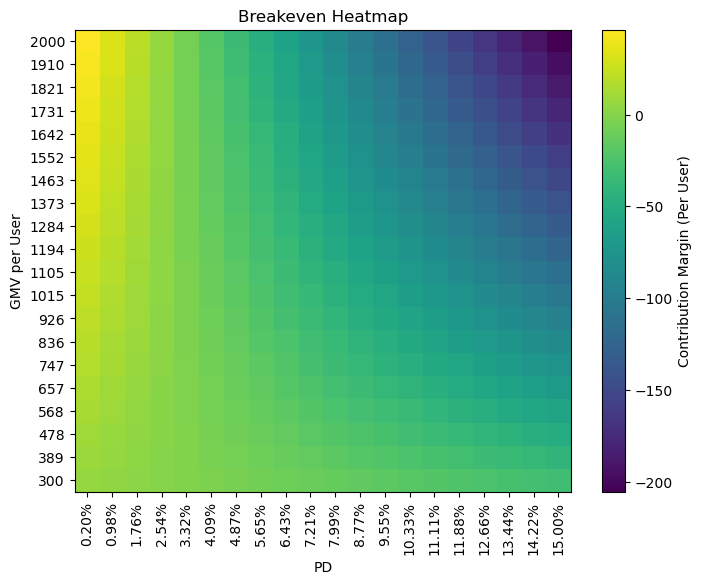

In [55]:
gmv_range = np.linspace(300, 2000, 20)
pd_range = np.linspace(0.002, 0.15, 20)

breakeven = np.zeros((len(gmv_range), len(pd_range)))

for i, gmv in enumerate(gmv_range):
    for j, pd_ in enumerate(pd_range):
        rev = gmv * MDR
        cost = COST_FIXED + gmv * COST_VARIABLE
        loss = gmv * pd_ * LGD
        breakeven[i, j] = rev - cost - loss

plt.figure(figsize=(8,6))
plt.imshow(breakeven, aspect="auto", origin="lower")
plt.colorbar(label="Contribution Margin (Per User)")
plt.xticks(range(len(pd_range)), [f"{x:.2%}" for x in pd_range], rotation=90)
plt.yticks(range(len(gmv_range)), [int(x) for x in gmv_range])
plt.title("Breakeven Heatmap")
plt.xlabel("PD")
plt.ylabel("GMV per User")
plt.show()


### Scenario Sweep

In [56]:
# === MACRO SCENARIO CONFIGURATION ===

macro_scenarios = {
    "baseline": {
        "pd_stress": 0.00,      # no PD inflation
        "gmv_contraction": 0.00 # no GMV hit
    },
    "mild_recession": {
        "pd_stress": 0.30,      # +30% PD inflation
        "gmv_contraction": 0.10 # -10% GMV
    },
    "severe_recession": {
        "pd_stress": 0.70,      # +70% PD inflation
        "gmv_contraction": 0.25 # -25% GMV
    }
}

# User base sizes for scalability stress
user_sizes = [10_000, 50_000, 200_000, 1_000_000]


In [57]:
# === SYNTHETIC USER GENERATION (your logic wrapped as a function) ===

def generate_synthetic_users(N_USERS, gmv_mean=300, gmv_sigma=1.0):
    mu = np.log(gmv_mean) - (gmv_sigma**2 / 2)
    user_gmv = np.random.lognormal(mean=mu, sigma=gmv_sigma, size=N_USERS)

    users = pd.DataFrame({
        "user_id": np.arange(N_USERS),
        "annual_gmv": user_gmv
    })
    return users


In [58]:
# === APPLY YOUR EXISTING RISK TIER CONFIGURATION ===

tiers = [
    ("A", 0.003, 0.50),
    ("B", 0.015, 0.30),
    ("C", 0.040, 0.15),
    ("D", 0.100, 0.05),
]

tier_labels, tier_pds, tier_weights = zip(*tiers)

def assign_risk_tiers(users):
    users["risk_tier"] = np.random.choice(
        tier_labels,
        size=len(users),
        p=tier_weights
    )
    pd_map = {t: pd for t, pd, w in tiers}
    users["pd"] = users["risk_tier"].map(pd_map)
    
    # constant LGD from your notebook
    users["lgd"] = 0.85
    
    return users


In [59]:
# === UNIT ECONOMICS CALCULATOR ===

def compute_economics(users, mdr=0.04, opex_per_user=15, funding_rate=0.06):
    """
    Computes portfolio-level economics.
    Uses:
      - annual_gmv (or gmv_adj after stress)
      - pd
      - lgd
    """
    
    # MDR revenue
    users["revenue"] = users["gmv_adj"] * mdr

    # Expected loss
    users["expected_loss"] = users["gmv_adj"] * users["pd"] * users["lgd"]

    # Funding cost = GMV * funding_rate
    users["funding_cost"] = users["gmv_adj"] * funding_rate

    # Opex: per-user
    users["opex"] = opex_per_user

    # Profit
    users["profit"] = users["revenue"] - users["expected_loss"] - users["funding_cost"] - users["opex"]

    portfolio_profit = users["profit"].sum()

    return portfolio_profit, users


In [60]:
# === MACRO × USER SIZE SWEEP ===

scenario_results = []

for scenario_name, cfg in macro_scenarios.items():

    pd_stress = cfg["pd_stress"]
    gmv_hit = cfg["gmv_contraction"]

    for N in user_sizes:

        # Step 1: generate users
        users = generate_synthetic_users(N)
        users = assign_risk_tiers(users)

        # Step 2: apply GMV contraction
        users["gmv_adj"] = users["annual_gmv"] * (1 - gmv_hit)

        # Step 3: apply PD inflation
        users["pd"] = (users["pd"] * (1 + pd_stress)).clip(0, 1)

        # Step 4: compute economics
        profit, df = compute_economics(users)

        scenario_results.append({
            "scenario": scenario_name,
            "users": N,
            "profit": profit
        })

scenario_df = pd.DataFrame(scenario_results)
scenario_df


,scenario,users,profit
0,baseline,10000,-2.536649e+05
1,baseline,50000,-1.261630e+06
2,baseline,200000,-5.064514e+06
3,baseline,1000000,-2.530974e+07
4,mild_recession,10000,-2.551950e+05
5,mild_recession,50000,-1.270628e+06
6,mild_recession,200000,-5.088573e+06
7,mild_recession,1000000,-2.545278e+07
8,severe_recession,10000,-2.503212e+05
9,severe_recession,50000,-1.256392e+06


In [61]:
# === SCENARIO SUMMARY TABLE ===

summary = scenario_df.pivot(index="users", columns="scenario", values="profit")
summary = summary.applymap(lambda x: round(x, 2))
summary


/var/folders/2_/skwfrb393zjdzz43_1hyfg8m0000gq/T/ipykernel_99029/4182817416.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  summary = summary.applymap(lambda x: round(x, 2))


scenario,baseline,mild_recession,severe_recession
users,,,
10000,-253664.89,-255194.99,-250321.21
50000,-1261630.08,-1270627.73,-1256391.98
200000,-5064513.58,-5088572.75,-5012407.05
1000000,-25309739.48,-25452778.54,-25031833.91


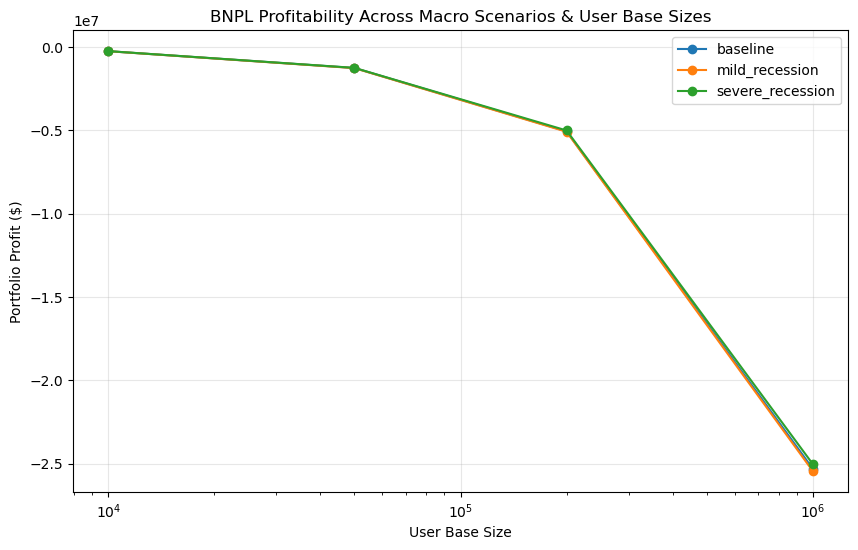

In [62]:
# === PLOT PROFIT SCENARIO VS USER BASE ===

plt.figure(figsize=(10,6))

for scenario_name in macro_scenarios.keys():
    plt.plot(
        summary.index,
        summary[scenario_name],
        marker="o",
        label=scenario_name
    )

plt.title("BNPL Profitability Across Macro Scenarios & User Base Sizes")
plt.xlabel("User Base Size")
plt.ylabel("Portfolio Profit ($)")
plt.xscale("log")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


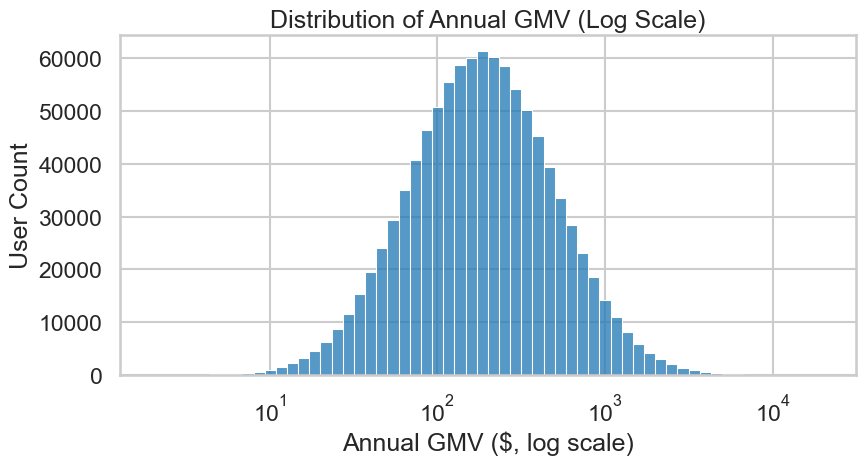

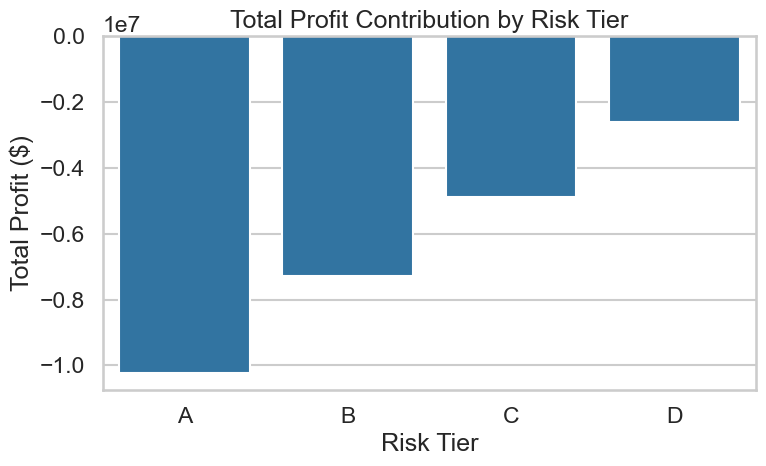

/var/folders/2_/skwfrb393zjdzz43_1hyfg8m0000gq/T/ipykernel_99029/4165435707.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tier_loss_rate = users.groupby("risk_tier").apply(lambda x: (x.pd * x.lgd).mean())


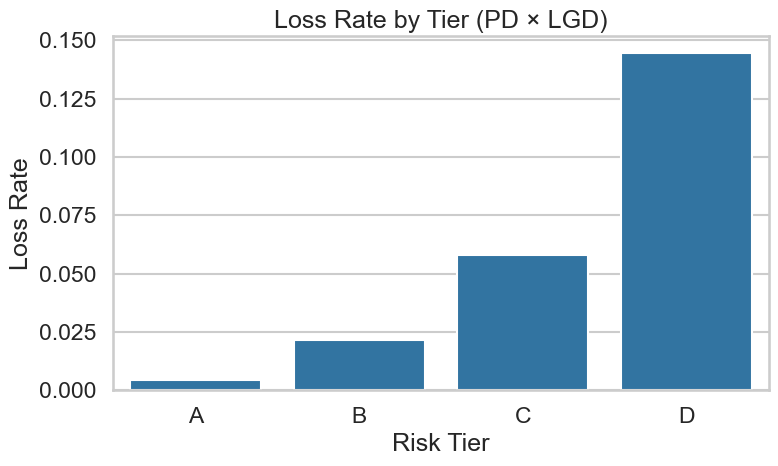

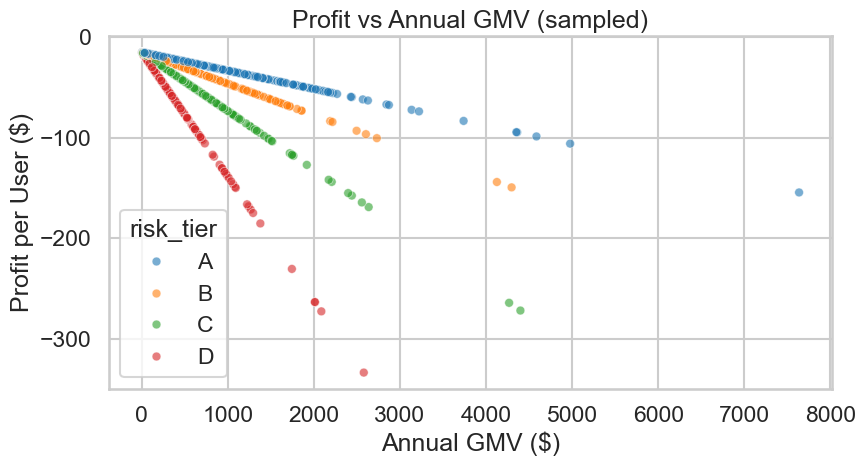

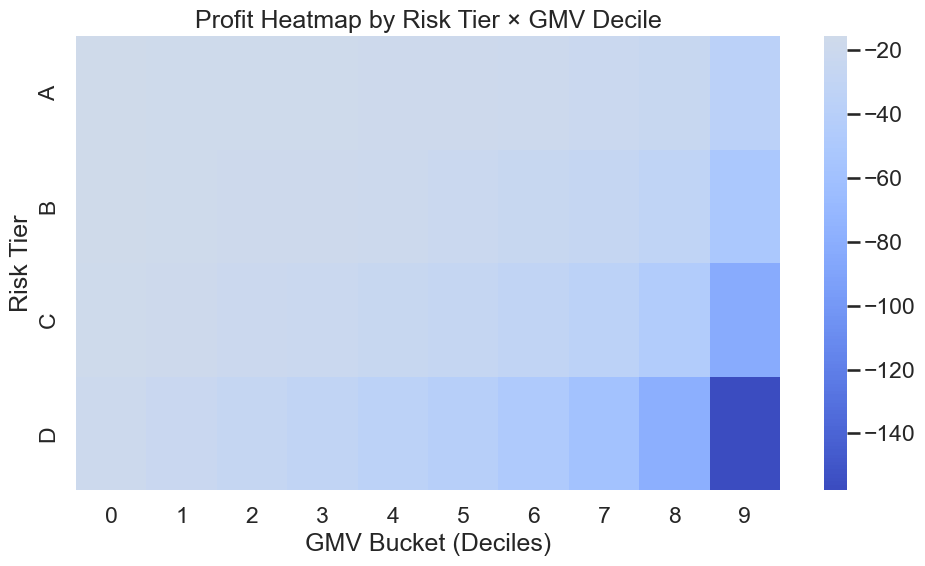

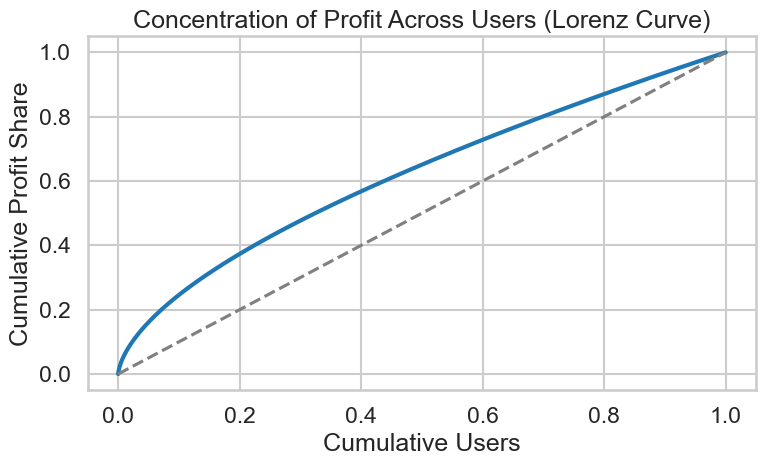

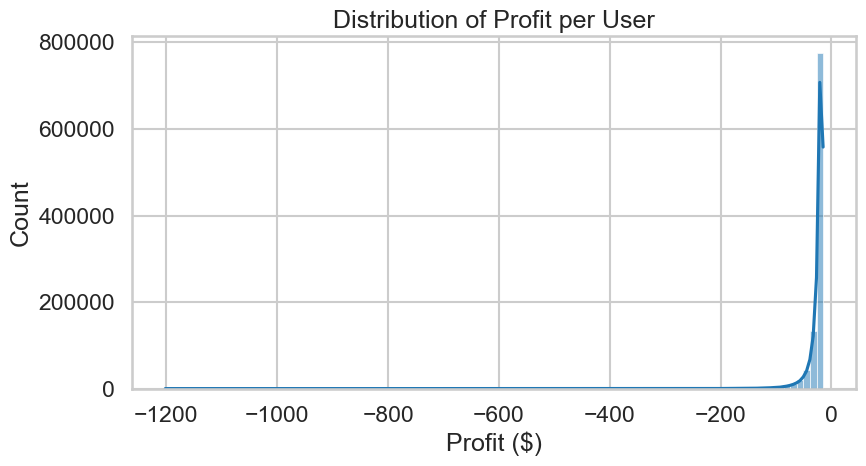


=== PORTFOLIO SUMMARY ===


,Total Users,Total GMV,Total Profit,Avg Profit/User,Portfolio Loss Rate
0,"1,000,000.00","299,954,881.69","-25,031,833.91",-25.03,0.02


In [63]:
# ===========================================================
# === ADDITIONAL VISUALIZATIONS FOR REPORTING / APPENDIX ===
# ===========================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set_style("whitegrid")
sns.set_context("talk")

# -----------------------------------------------------------
# 1. Distribution of Annual GMV (Log scale + clean histogram)
# -----------------------------------------------------------
plt.figure(figsize=(9,5))
sns.histplot(users['annual_gmv'], bins=60, log_scale=True)
plt.title("Distribution of Annual GMV (Log Scale)")
plt.xlabel("Annual GMV ($, log scale)")
plt.ylabel("User Count")
plt.tight_layout()
plt.show()

# -----------------------------------------------------------
# 2. Profit Contribution by Risk Tier (Bar chart)
# -----------------------------------------------------------
if "profit" in users.columns:
    tier_profit = users.groupby("risk_tier")["profit"].sum().sort_index()
    plt.figure(figsize=(8,5))
    sns.barplot(x=tier_profit.index, y=tier_profit.values)
    plt.title("Total Profit Contribution by Risk Tier")
    plt.xlabel("Risk Tier")
    plt.ylabel("Total Profit ($)")
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------------
# 3. Loss Rate by Tier (PD * LGD) – bar plot
# -----------------------------------------------------------
tier_loss_rate = users.groupby("risk_tier").apply(lambda x: (x.pd * x.lgd).mean())
plt.figure(figsize=(8,5))
sns.barplot(x=tier_loss_rate.index, y=tier_loss_rate.values)
plt.title("Loss Rate by Tier (PD × LGD)")
plt.ylabel("Loss Rate")
plt.xlabel("Risk Tier")
plt.tight_layout()
plt.show()

# -----------------------------------------------------------
# 4. Profit vs GMV Scatter (colored by risk tier)
# -----------------------------------------------------------
if "profit" in users.columns:
    plt.figure(figsize=(9,5))
    sns.scatterplot(data=users.sample(min(5000, len(users))),  # subsample for speed
                    x="annual_gmv", y="profit", hue="risk_tier", alpha=0.6, s=40)
    plt.title("Profit vs Annual GMV (sampled)")
    plt.xlabel("Annual GMV ($)")
    plt.ylabel("Profit per User ($)")
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------------
# 5. Heatmap of Average Profit by Risk Tier × GMV Bucket
# -----------------------------------------------------------
users["gmv_bucket"] = pd.qcut(users["annual_gmv"], 10, labels=False)
pivot = users.groupby(["risk_tier","gmv_bucket"])["profit"].mean().unstack()

plt.figure(figsize=(10,6))
sns.heatmap(pivot, cmap="coolwarm", center=0)
plt.title("Profit Heatmap by Risk Tier × GMV Decile")
plt.xlabel("GMV Bucket (Deciles)")
plt.ylabel("Risk Tier")
plt.tight_layout()
plt.show()

# -----------------------------------------------------------
# 6. Lorenz-style curve: cumulative users vs cumulative profit
# -----------------------------------------------------------
if "profit" in users.columns:
    df_sorted = users.sort_values("profit")
    df_sorted["cum_users"] = np.linspace(0,1,len(df_sorted))
    df_sorted["cum_profit"] = df_sorted["profit"].cumsum() / df_sorted["profit"].sum()

    plt.figure(figsize=(8,5))
    plt.plot(df_sorted["cum_users"], df_sorted["cum_profit"], lw=3)
    plt.plot([0,1],[0,1],"--",color="grey")
    plt.title("Concentration of Profit Across Users (Lorenz Curve)")
    plt.xlabel("Cumulative Users")
    plt.ylabel("Cumulative Profit Share")
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------------
# 7. ROI Distribution – histogram
# -----------------------------------------------------------
if "profit" in users.columns:
    plt.figure(figsize=(9,5))
    sns.histplot(users["profit"], bins=100, kde=True)
    plt.title("Distribution of Profit per User")
    plt.xlabel("Profit ($)")
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------------
# 8. Summary Table (printed nicely)
# -----------------------------------------------------------
summary_table = pd.DataFrame({
    "Total Users": [len(users)],
    "Total GMV": [users["annual_gmv"].sum()],
    "Total Profit": [users["profit"].sum()] if "profit" in users else [np.nan],
    "Avg Profit/User": [users["profit"].mean()] if "profit" in users else [np.nan],
    "Portfolio Loss Rate": [(users["pd"] * users["lgd"]).mean()],
})

print("\n=== PORTFOLIO SUMMARY ===")
display(summary_table.style.format("{:,.2f}"))


###

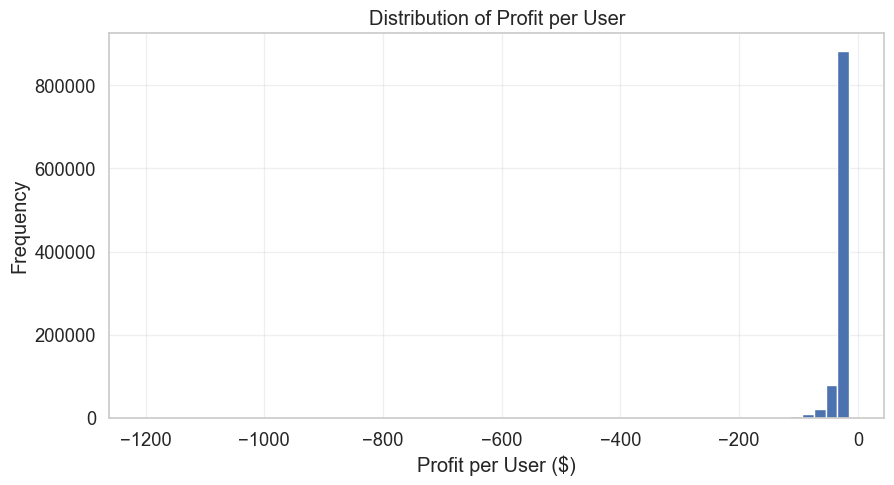

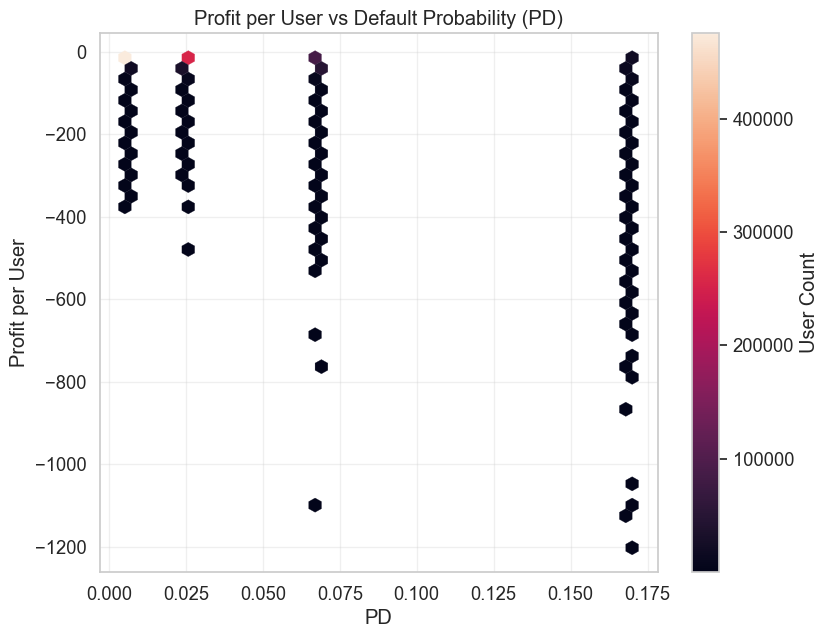

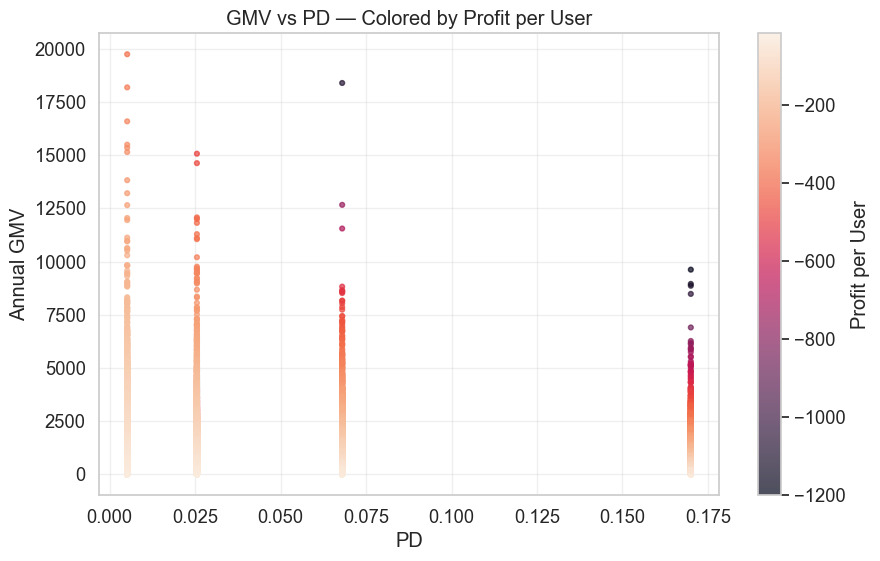

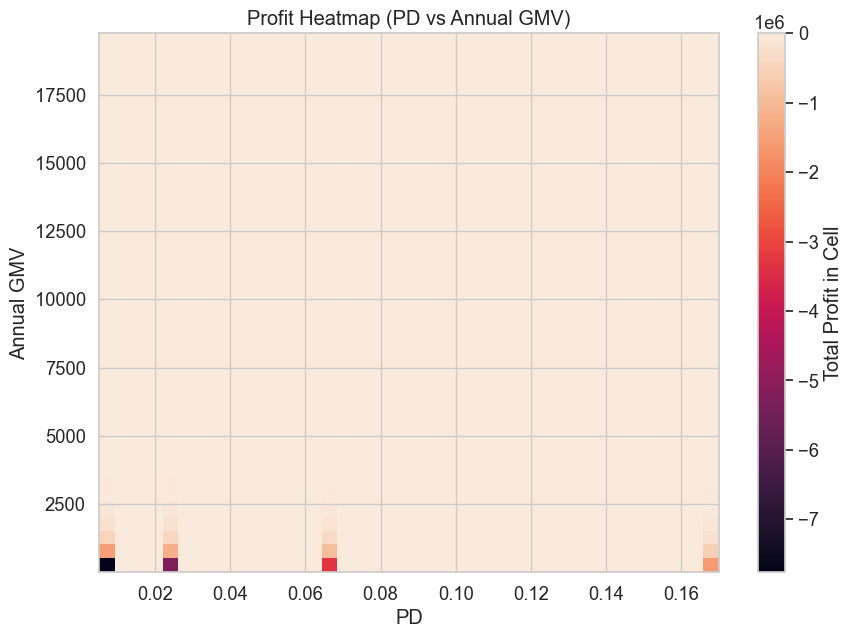


=== PROFIT SUMMARY BY PD BUCKET ===


/var/folders/2_/skwfrb393zjdzz43_1hyfg8m0000gq/T/ipykernel_99029/2859892582.py:95: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = users.groupby('pd_bucket').agg(


,avg_profit,median_profit,user_count
pd_bucket,,,
"(0.0, 0.1]",-23.609508,-19.692081,949792
"(0.1, 0.2]",-51.938171,-37.486354,50208
"(0.2, 0.5]",NaN,NaN,0
"(0.5, 1.0]",NaN,NaN,0


In [65]:
# === ADDITIONAL VISUALIZATIONS ===
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------
# Ensure required fields exist
# ------------------------------------------------------------
# Standardize GMV column name
gmv_col = 'annual_gmv' if 'annual_gmv' in users.columns else 'user_gmv'

# If your script already computed profit_per_user, reuse it
if 'profit_per_user' not in users.columns:
    if 'profit' in users.columns:
        users['profit_per_user'] = users['profit']
    else:
        raise ValueError("Your script must compute either profit or profit_per_user before visualizations.")

# ------------------------------------------------------------
# 1. Histogram of Profit per User
# ------------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.hist(users['profit_per_user'], bins=60)
plt.title("Distribution of Profit per User")
plt.xlabel("Profit per User ($)")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

# ------------------------------------------------------------
# 2. Hexbin: Profit vs Default Probability
# ------------------------------------------------------------
plt.figure(figsize=(9, 7))
plt.hexbin(
    users['pd'],
    users['profit_per_user'],
    gridsize=40,
    mincnt=1,
    linewidths=0.2
)
plt.colorbar(label='User Count')
plt.title("Profit per User vs Default Probability (PD)")
plt.xlabel("PD")
plt.ylabel("Profit per User")
plt.grid(alpha=0.3)
plt.show()

# ------------------------------------------------------------
# 3. GMV vs PD Scatter — Color by Profit
# ------------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(
    users['pd'], 
    users[gmv_col],
    c=users['profit_per_user'],
    s=12,
    alpha=0.7
)
plt.title("GMV vs PD — Colored by Profit per User")
plt.xlabel("PD")
plt.ylabel("Annual GMV")
plt.colorbar(label="Profit per User")
plt.grid(alpha=0.3)
plt.show()

# ------------------------------------------------------------
# 4. Profit Heatmap: PD (x-axis) × GMV (y-axis)
# ------------------------------------------------------------
pd_bins = np.linspace(users['pd'].min(), users['pd'].max(), 40)
gmv_bins = np.linspace(users[gmv_col].min(), users[gmv_col].max(), 40)

heatmap, xedges, yedges = np.histogram2d(
    users['pd'], 
    users[gmv_col], 
    bins=[pd_bins, gmv_bins], 
    weights=users['profit_per_user']
)

plt.figure(figsize=(10, 7))
plt.imshow(
    heatmap.T,
    origin='lower',
    aspect='auto',
    extent=[pd_bins.min(), pd_bins.max(), gmv_bins.min(), gmv_bins.max()]
)
plt.title("Profit Heatmap (PD vs Annual GMV)")
plt.xlabel("PD")
plt.ylabel("Annual GMV")
plt.colorbar(label="Total Profit in Cell")
plt.show()

# ------------------------------------------------------------
# 5. Table Summary — Profitability Buckets
# ------------------------------------------------------------
users['pd_bucket'] = pd.cut(users['pd'], bins=[0, 0.1, 0.2, 0.5, 1.0])
summary = users.groupby('pd_bucket').agg(
    avg_profit=('profit_per_user', 'mean'),
    median_profit=('profit_per_user', 'median'),
    user_count=('profit_per_user', 'size')
)

print("\n=== PROFIT SUMMARY BY PD BUCKET ===")
display(summary)


###

###

###

###